## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## 1. Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### 1.1 Get the images for calibation and test

In [2]:
# Make a list of calibration images
cal_images = glob.glob('./camera_cal/calibration*.jpg')
# Make a list of test images
test_images = glob.glob("test_images/test*.jpg")

#### 1.2 Compute calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in cal_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(50)

cv2.destroyAllWindows()

In [5]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

## 2. Undistortion

#### 2.1 unditort chess board image

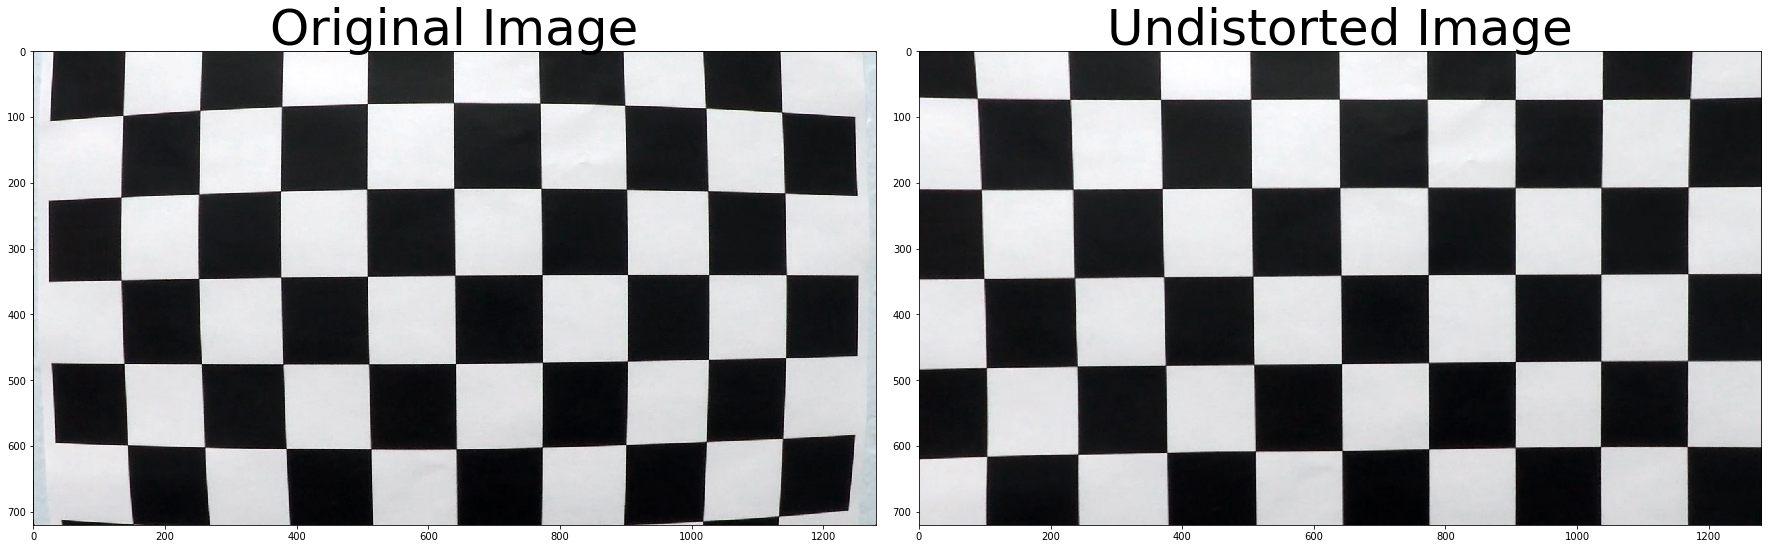

In [6]:
orignal_image = cv2.imread(cal_images[0])
undisorted_image = cv2.undistort(orignal_image, mtx, dist, None, mtx)

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
figure.tight_layout()
ax1.imshow(orignal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undisorted_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.imsave("./test_images/undistored_image.jpg",undisorted_image)

#### 2.2 undistort test image

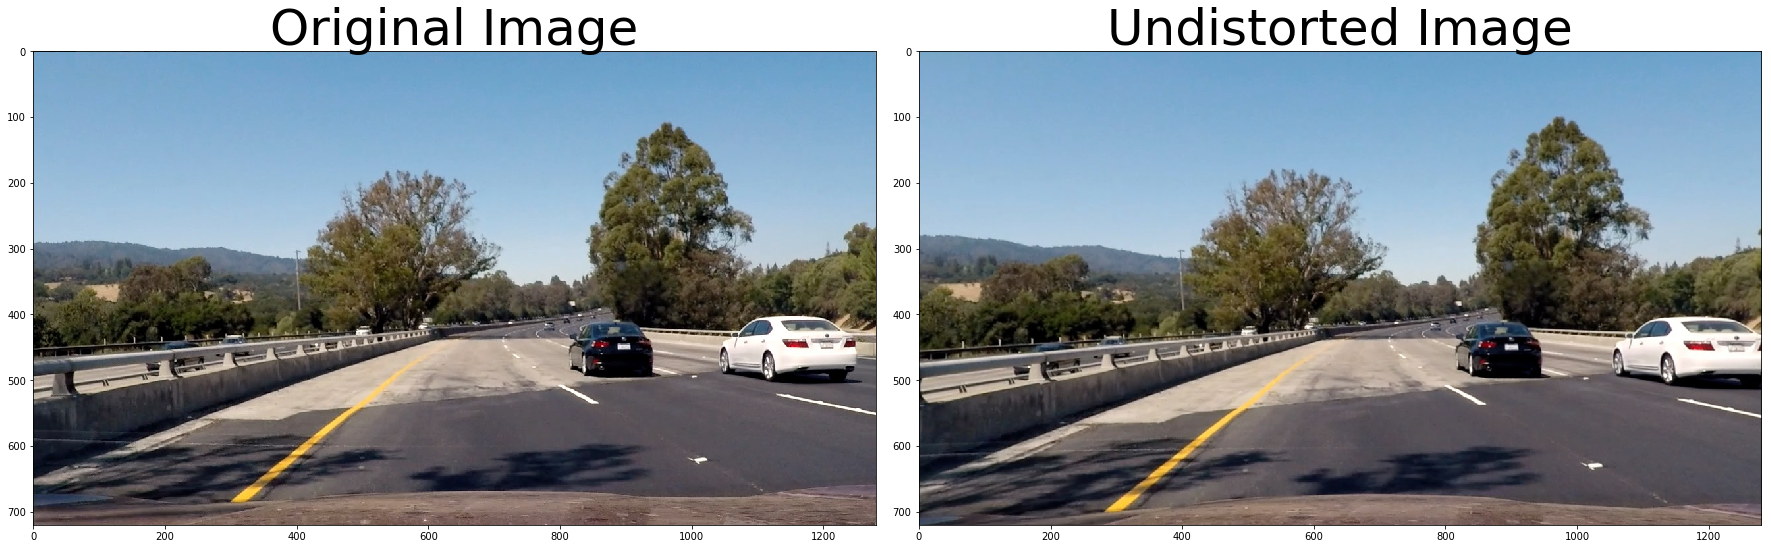

In [7]:
test_image = plt.imread(test_images[3])
test_image_undisted = cv2.undistort(test_image, mtx, dist, None, mtx)

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
figure.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_image_undisted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#plt.imsave('test_images/test_image_3_undisorted.jpg',test_image_undisted)

## 3. Color/gradient threshold

#### 3.1 Apply Sobel

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_thresh=(30,120)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Return the result
    return binary_output

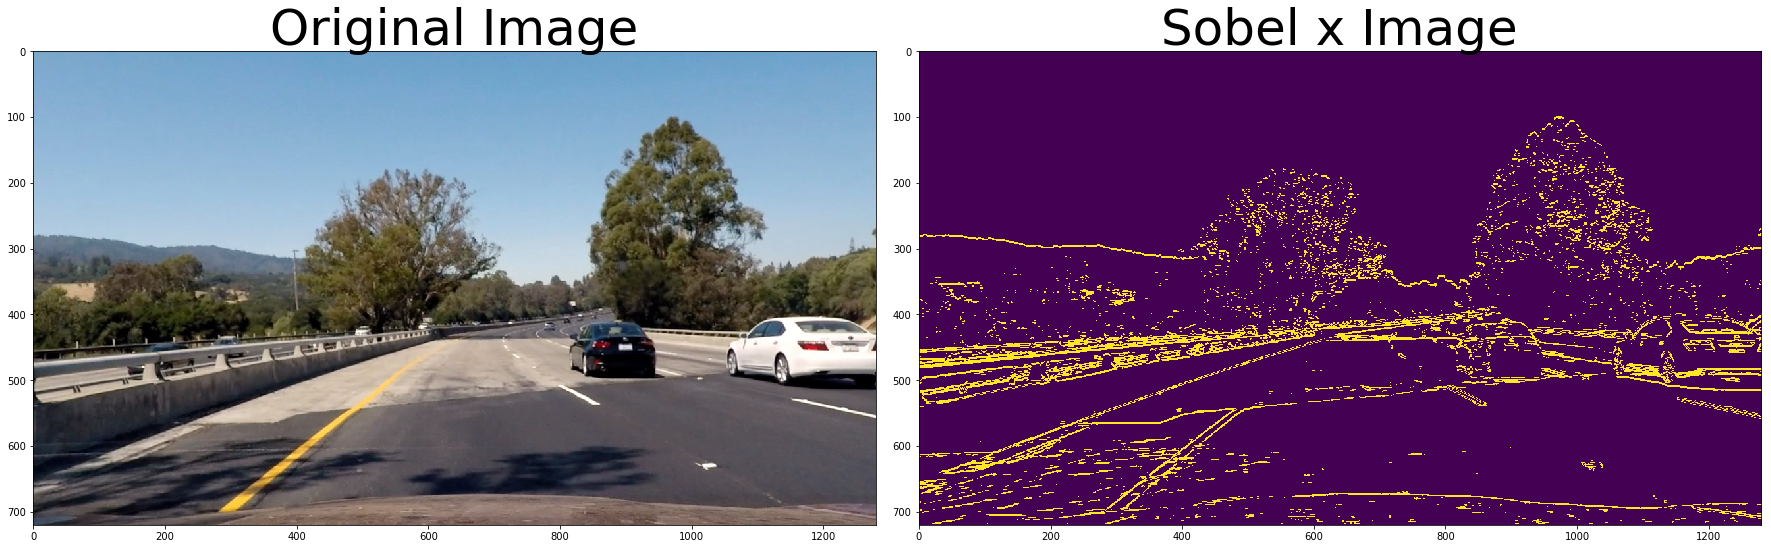

In [9]:
test_image = plt.imread(test_images[3])
test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
test_image_sobel_x = abs_sobel_thresh(test_image,'y', (30, 120))

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
figure.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_image_sobel_x)
ax2.set_title('Sobel x Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3.2 Magnitude of the Gradient

In [10]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

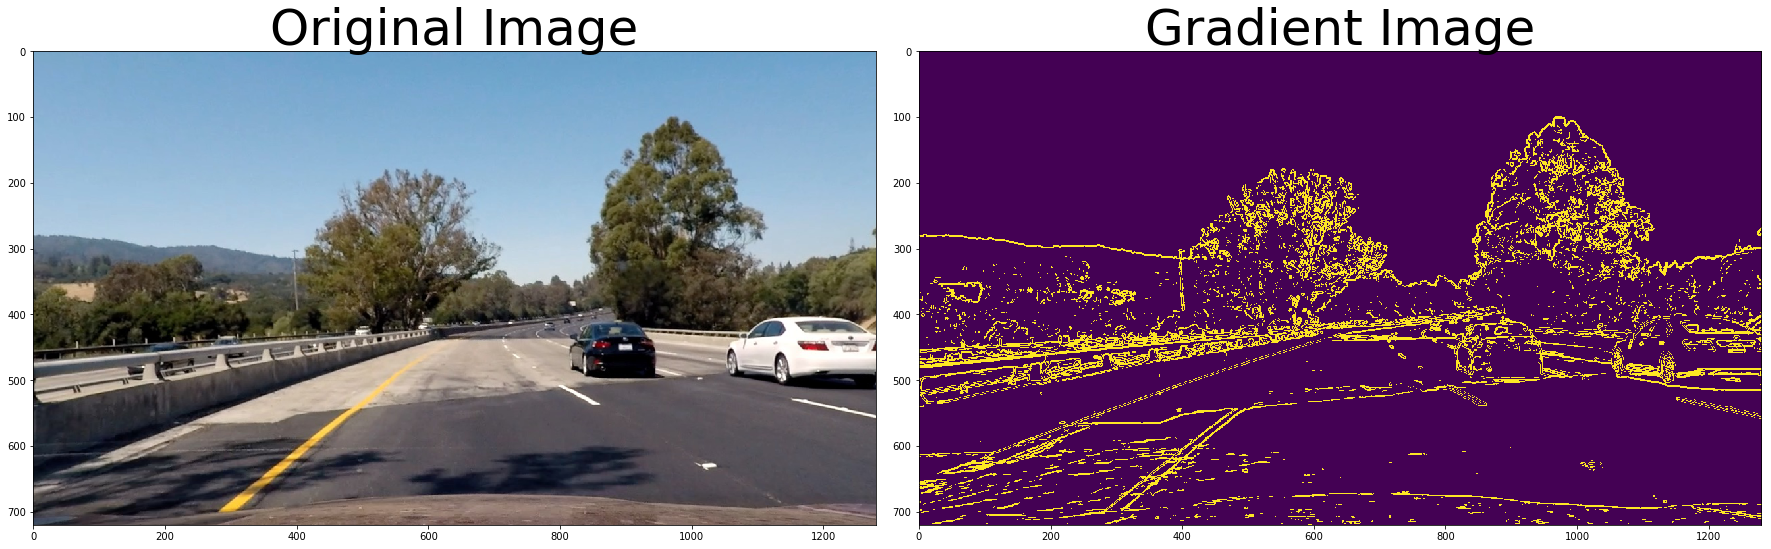

In [11]:
test_image = plt.imread(test_images[3])
test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
test_image_mag_thresh = mag_thresh(test_image, sobel_kernel=3, mag_thresh=(30,100))

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
figure.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_image_mag_thresh)
ax2.set_title('Gradient Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3.3 Direction of the Gradient

In [12]:
def dir_thresh(img, sobel_kernel=3, dir_thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

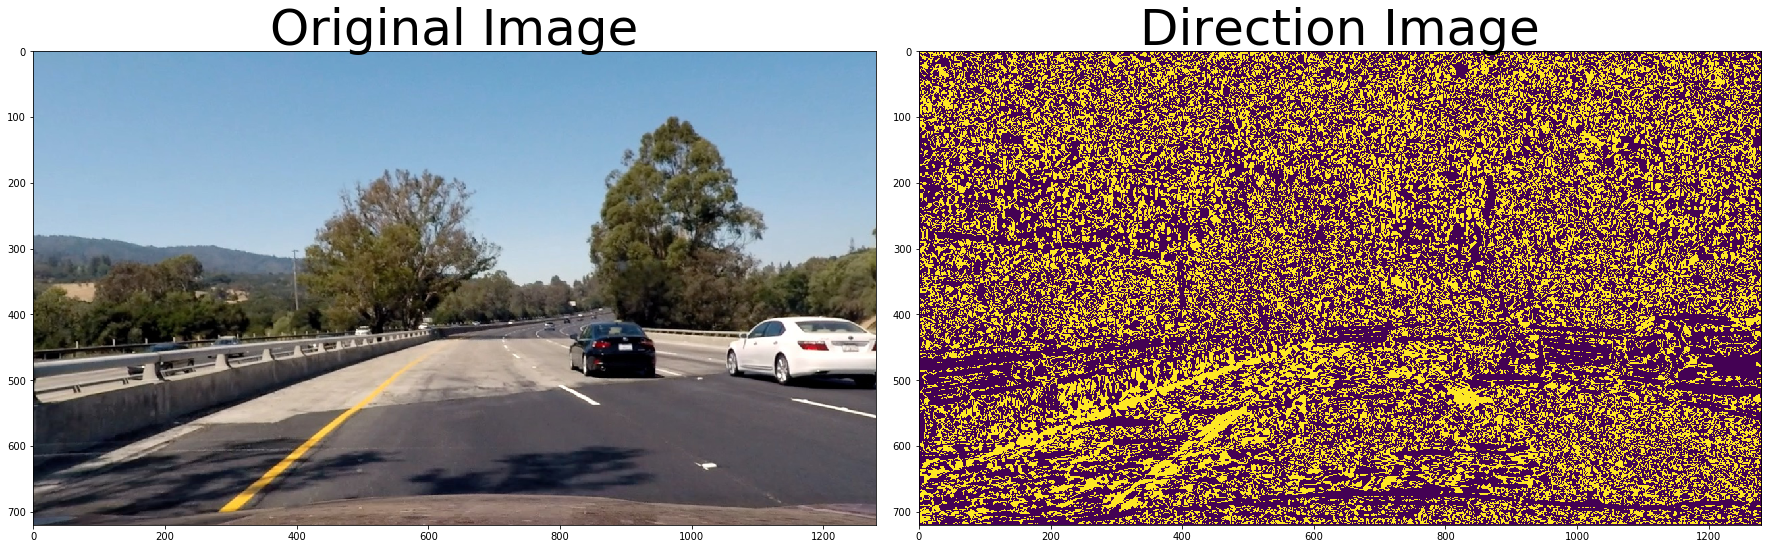

In [13]:
test_image = plt.imread(test_images[3])
test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
test_image_dir_gradient = dir_thresh(test_image, sobel_kernel=15, dir_thresh =(0.7,1.3))

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
figure.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_image_dir_gradient)
ax2.set_title('Direction Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3.4 Hls select

In [14]:
def hls_select(img, s_thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    img_hls_select = img[:]
    img_hls_select = cv2.bitwise_and(img_hls_select,img_hls_select,mask = s_binary)
    return s_binary, img_hls_select

In [15]:
def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask

In [16]:
def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask

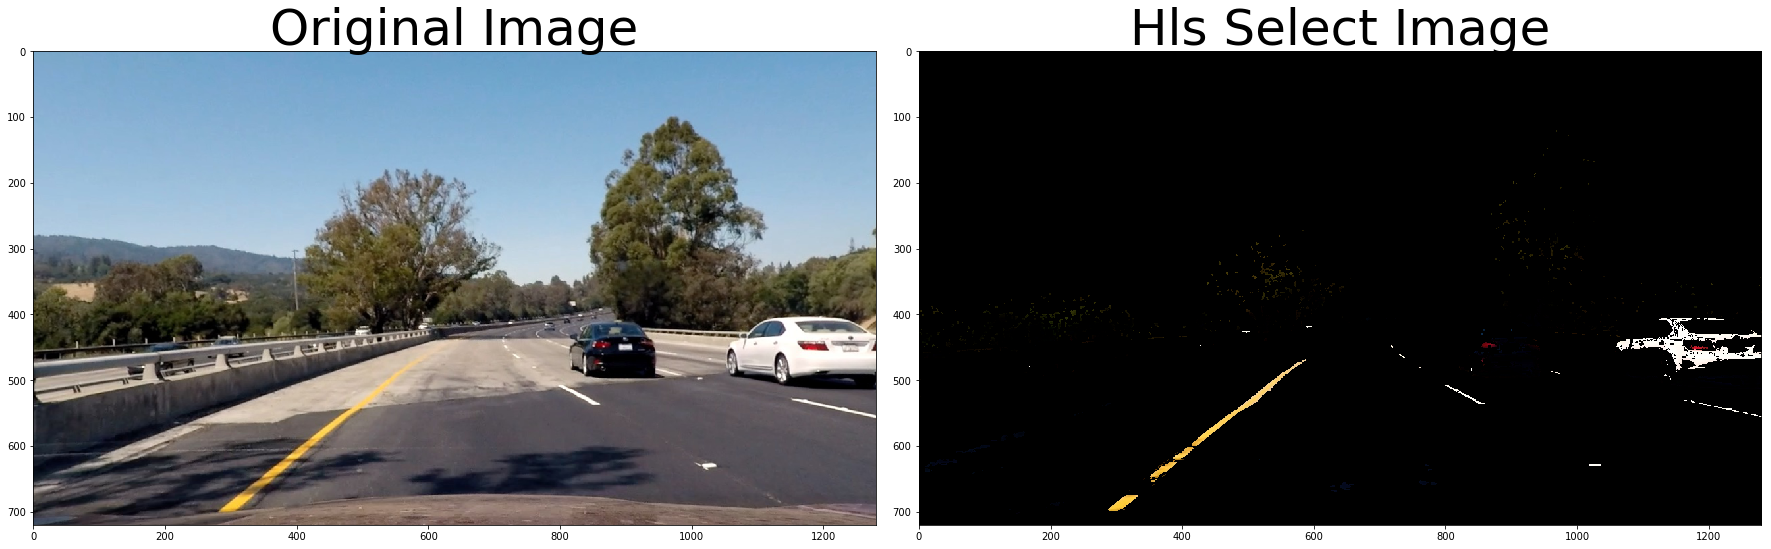

In [17]:
test_image = plt.imread(test_images[3])
test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
_, test_image_hls_select = hls_select(test_image, s_thresh =(170,  255))

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
figure.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_image_hls_select)
ax2.set_title('Hls Select Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3.5 Combine threshold

In [18]:
def combine_previous(img, ksize=3, gradx_thr=(30,100), mag_thr=(30,100), dir_thr=(0.7,1.3),s_thr=(170,255)):
    # Choose a Sobel kernel size
    # ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_thresh = gradx_thr)
    mag_binary = mag_thresh(img, sobel_kernel = ksize, mag_thresh = mag_thr)
    dir_binary = dir_thresh(img, sobel_kernel = 15, dir_thresh = dir_thr)
    s_binary,_ = hls_select(img, s_thresh = s_thr)                           
    combine_binary = np.zeros_like(gradx)
    combine_binary[(gradx == 1)| ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    img_combine = cv2.bitwise_and(img,img,mask = combine_binary)
    return img_combine,combine_binary

In [19]:
def comb_thresh(image):
    yellow = select_yellow(image)
    white = select_white(image)
    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1
    #_, combined_binary_pre = combine_previous(image)
    img_combined = cv2.bitwise_and(image,image,mask = combined_binary)
    # combined_binary = cv2.bitwise_or(combined_binary, combined_binary_pre)
    return img_combined,combined_binary

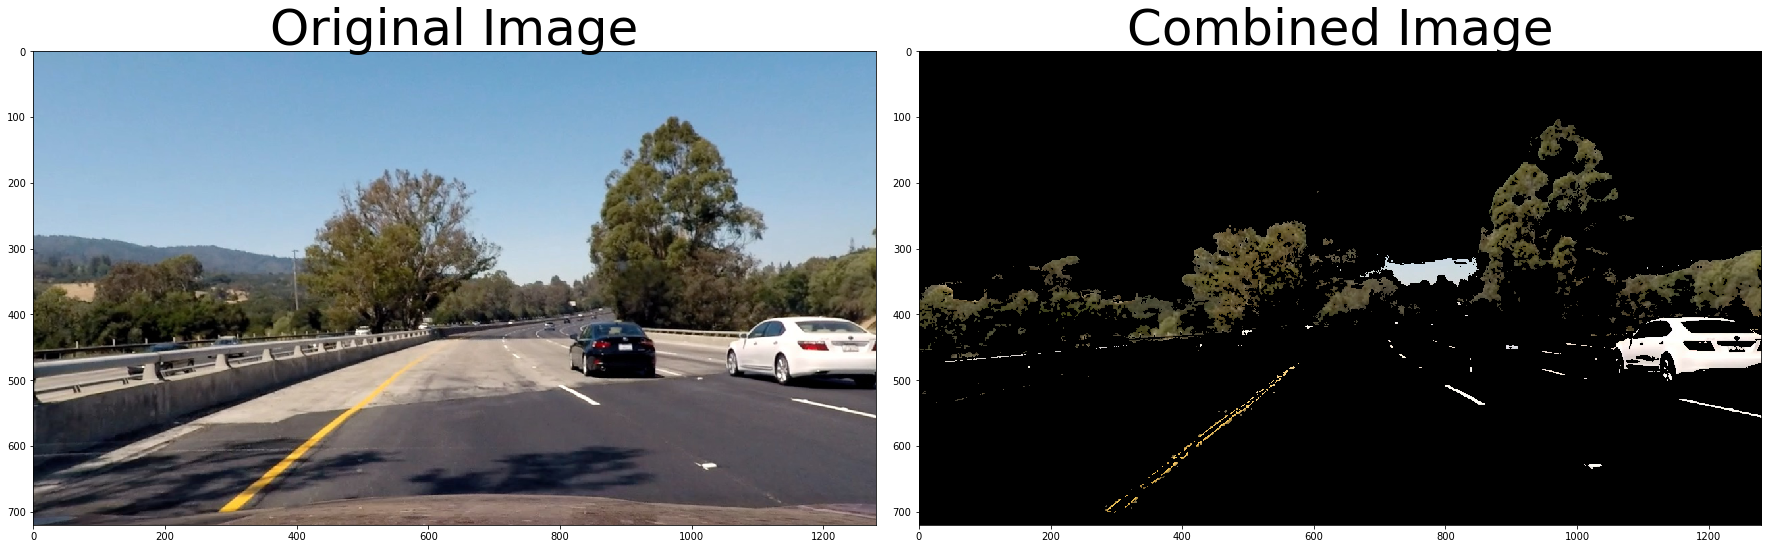

In [20]:
test_image = plt.imread(test_images[3])
test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
#test_image_combined,_ = combine(test_image, ksize=3, gradx_thr= (30,100),mag_thr =(30, 100), dir_thr = (0.7,1.3), s_thr= (170,255))
test_image_combined,_ = comb_thresh(test_image)
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
figure.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_image_combined, cmap='gray')
ax2.set_title('Combined Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave('./test_images/combined_image.jpg', test_image_combined)

## 4. Perspective transform

#### 4.1 Select source points and show

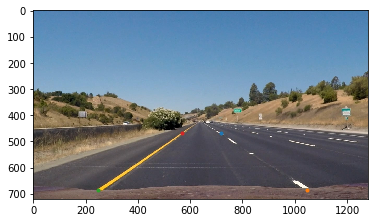

In [21]:
straight_img = plt.imread('test_images/straight_lines1.jpg')
plt.imshow(straight_img)
plt.plot(718,468,'.')  #top right
plt.plot(1046,684,'.') #bottom right
plt.plot(248,684,'.')  #bottom left
plt.plot(568,468,'.')  #top left

   #### 4.2 Transform

In [22]:
def warped(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[718,468],
                     [1046,684],
                     [248,684],
                     [568,468]])
    dst = np.float32([[920,0],
                     [920,720],
                     [220,720],
                     [220,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,Minv

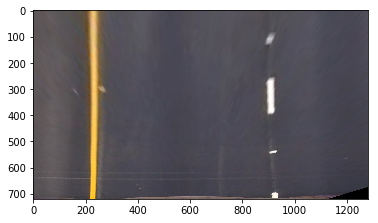

In [23]:
image_warped,_ = warped(straight_img)
plt.imshow(image_warped)
#plt.imsave("./test_images/warped_image.jpg",image_warped)

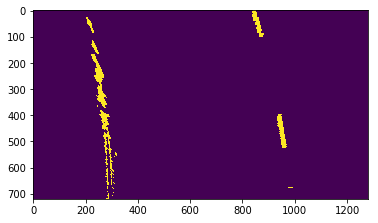

In [25]:
video_frame = plt.imread('test_images/video_frame.png',cv2.CV_8U)
video_frame_undistort = cv2.undistort(video_frame[:,:,:3], mtx, dist, None, mtx)
#video_frame_combined, video_frame_binary = combine(video_frame_undistort,ksize=3, gradx_thr= (30,100),mag_thr =(30, 100), dir_thr = (0.7,1.3), s_thr= (170,255))
_,video_frame_binary = comb_thresh(video_frame_undistort)
binary_warped,_ = warped(video_frame_binary)
plt.imshow(binary_warped)

## 5.Find the lines

#### 5.1 Peaks in a Histogram

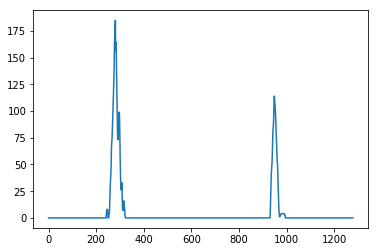

In [26]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis= 0) # // is int in python 3
plt.plot(histogram)

#### 5.2 Fit the line

In [27]:
def fit_line(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]/2)
    
    #Find the peak of the left and right halves of the histogram
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #The number of sliding windows
    nwindows = 9
    window_height = np.int(binary_warped.shape[0] // nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set mininmum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #left_points = zip(leftx,lefty)
    #right_points = zip(rightx, righty)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    return left_fit,right_fit, ploty

298.059271171
986.764595805


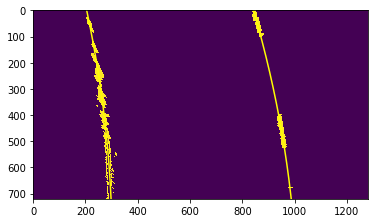

In [28]:
left_fit, right_fit, ploty = fit_line(binary_warped)
out_img_ = np.dstack((binary_warped, binary_warped, binary_warped))*255
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
out_img_[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img_[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img_)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(binary_warped)
print(left_fitx[719])
print(right_fitx[719])

In [29]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
#ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
print(left_fitx[719])
print(right_fitx[719])

298.059271171
986.764595805


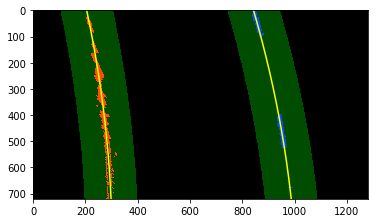

In [30]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.imsave('./test_images/fit_line.jpg',result)

## 6. Calculate Curvature

In [58]:
def calculate_curvature(left_fit,right_fit,ploty):
    y_eval = np.max(ploty)
    #print(ploty)

    left_curverad_pix = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad_pix = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension #Part 4.2

    # Fit new polynomials to x,y in world space
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#     rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)  
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    center_fit_cr = np.polyfit(ploty*ym_per_pix, (leftx+rightx)/2*xm_per_pix,2)
    
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     center_curverad = ((1 + (2*center_fit_cr[0]*y_eval*ym_per_pix + center_fit_cr[1])**2)**1.5) / np.absolute(2*center_fit_cr[0])
    offset_center = ((leftx[719] + rightx[719])/2 - 640)*xm_per_pix    
#     print(leftx[719],rightx[719])
#     print(left_curverad, 'm', right_curverad, 'm [',offset_center, ' m ] ')
    return left_curverad, right_curverad, offset_center

In [59]:
_,_,_=calculate_curvature(left_fit, right_fit,ploty)

## 7. Process Frame

In [60]:
def process_frame(frame_img):
    
    frame_img = frame_img[:,:,0:3] # Do not consider alpha channel if it exits
    
    img_size = (frame_img.shape[1], frame_img.shape[0])

    frame_img_unditorted = cv2.undistort(frame_img,mtx,dist,None,mtx)
    
    #video_frame_combined, video_frame_binary = combine(frame_img_unditorted)
    _,video_frame_binary = comb_thresh(frame_img_unditorted)
    
    binary_warped,Minv = warped(video_frame_binary)
  
    left_fit,right_fit,ploty = fit_line(binary_warped)

    # Create an image to draw on and an image to show the selection window
    if(3 == frame_img.shape[2]):
        marked_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    elif(4 == frame_img.shape[2]):
        marked_img = np.dstack((binary_warped, binary_warped, binary_warped,binary_warped))*255
    
    offset_ = frame_img.shape[0]/2 + 100
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
#     left_fitx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
#     right_fitx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
      
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+offset_, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-offset_, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Mark the image
    cv2.fillPoly(marked_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(marked_img, np.int_([right_line_pts]), (0,255, 0))
    marked_img = cv2.warpPerspective(marked_img, Minv, img_size, flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(frame_img_unditorted, 1, marked_img, 0.3, 0)

    left_curvature, right_curvature, center_offset = calculate_curvature(left_fit, right_fit,ploty)
    avg_curvature = (left_curvature + right_curvature)/2
    text_curvature = 'The radius of the curvature is : %2f m'%avg_curvature

    text_offset_center = 'Offset of center : %2f m' % center_offset
    cv2.putText(result,text_curvature,(30,80),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
    cv2.putText(result,text_offset_center,(30,120),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
    
    return result

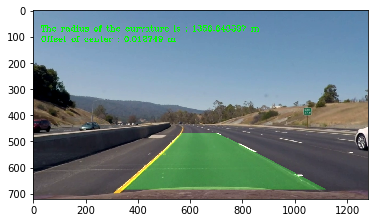

In [61]:
video_frame_process = process_frame(video_frame)
plt.imshow(video_frame_process)

In [62]:
plt.imsave("./test_images/video_frame.jpg",video_frame_process)

In [63]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio

white_output = 'test_videos_output/advanced_lane_line.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,26)
#print(clip1)
#plt.imshow(clip1)
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/advanced_lane_line.mp4
[MoviePy] Writing video test_videos_output/advanced_lane_line.mp4


100%|█████████▉| 1260/1261 [01:54<00:00, 11.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/advanced_lane_line.mp4 

CPU times: user 2min 36s, sys: 9.93 s, total: 2min 46s
Wall time: 1min 55s
